In [23]:
using DelaySSAToolkit
using Catalyst
using Statistics
using Test
using BenchmarkTools
using DataFrames

0 $\rightarrow$ $A_1$, $\rightarrow$ $A_2$, ..., $\rightarrow$ $A_5$ $\rightarrow$ 0 with delay 1 for each cascade delay

In [24]:
rn = @reaction_network begin
    5, 0 --> A1
end

Model ##ReactionSystem#283 with 1 equations
States (1):
  A1(t)
Parameters (0):

In [25]:
delay_trigger_affect! = []
chain_len = 10
delay_trigger_affect! = function (integrator, rng)
    append!(integrator.de_chan[1], 1.)
end

#19 (generic function with 1 method)

In [26]:
u0 = zeros(chain_len)
de_chan0 = []
for _ in 1:chain_len
    push!(de_chan0, [])
end
tspan = (0.,50.)
delay_complete_affect! = []
for i in 1:chain_len-1
    push!(delay_complete_affect!, function (integrator, rng)
        integrator.u[i] -= 1 # A_prev minus 1
        integrator.u[i+1] += 1 # A plus 1
        append!(integrator.de_chan[i+1], 1.) # add to the delay channel
    end
    )
end
push!(delay_complete_affect!, function (integrator, rng)
    integrator.u[chain_len] -= 1 # A_prev minus 1
end)

10-element Vector{Any}:
 #21 (generic function with 1 method)
 #21 (generic function with 1 method)
 #21 (generic function with 1 method)
 #21 (generic function with 1 method)
 #21 (generic function with 1 method)
 #21 (generic function with 1 method)
 #21 (generic function with 1 method)
 #21 (generic function with 1 method)
 #21 (generic function with 1 method)
 #23 (generic function with 1 method)

In [27]:
delay_trigger = Dict(Pair(1, delay_trigger_affect!))
delay_complete = Dict(i=>delay_complete_affect![i] for i in 1:chain_len)
delay_interrupt = Dict()
delayjumpset = DelayJumpSet(delay_trigger, delay_complete, delay_interrupt)
jumpsys = convert(JumpSystem, rn, combinatoric_ratelaws = false)
dprob = DiscreteProblem(jumpsys, u0, tspan)

DiscreteProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 50.0)
u0: 10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [28]:
algo_list =[DelayDirect(),DelayRejection(),DelayMNRM(),DelayDirectCR()]

4-element Vector{DelaySSAToolkit.AbstractDelayAggregatorAlgorithm}:
 DelayDirect()
 DelayRejection()
 DelayMNRM()
 DelayDirectCR()

In [33]:
medianlist=[]
for algo in algo_list
    djprob = DelayJumpProblem(jumpsys,dprob,algo,delayjumpset, de_chan0, save_positions=(false,false))
    a=@benchmark solve(djprob, SSAStepper())
    push!(medianlist,copy(median(a).time/1e9))
end
medianlist

4-element Vector{Any}:
 0.00295725
 0.01548885
 0.0156992
 0.01626

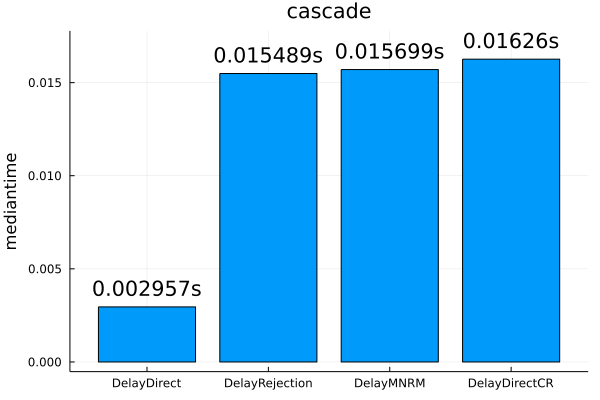

In [36]:
using Plots
medianvalue=[string(round(mt,digits=6),"s") for mt in medianlist]
algo_name = ["DelayDirect","DelayRejection","DelayMNRM","DelayDirectCR"]
bar(algo_name,medianlist,legend=:false,title="cascade",ylabel="mediantime")
scatter!(algo_name, 0.001 .+ medianlist , markeralpha=0, series_annotations=medianvalue)